In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
import pickle

from collections import defaultdict
import networkx as nx
from scipy.linalg import cholesky
from utils import *
from plot import *
from dubins import Dubins
# from propagate import DynamicModel,BeliefNode
with open('data/data.pickle', 'rb') as f:
    data_new = pickle.load(f)
    
env = data_new['env']
obj = data_new['obj']

# Code tests

Iteration: 0 vertices 1
Iteration: 499 vertices 248
Iteration: 998 vertices 490


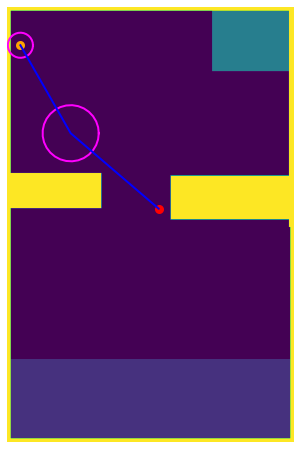

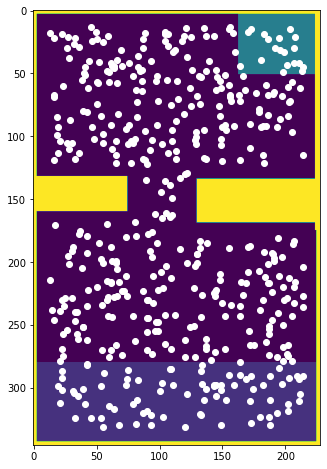

In [2]:
# testing params are in the  file
import code_tests as t
# from importlib import reload  
# t = reload(t)

t.test_path_vizualization(env)
sampling_iterations = 1000
cov_matrix_diag = 100
step = 100
t.check_sampling_and_steering(env,
                            sampling_iterations,
                            cov_matrix_diag,
                            step)

# GRAPH RRBT

In [3]:
class GraphRRTBNX:
    
    def __init__(self, start, end, step=75,k = 850,ellipse_number_of_points = 30, d_radius = 5, ang_weight = 1):
        self.start = start
        self.end = end
        self.step = step
        self.d_radius = d_radius 
        self.ang_weight = ang_weight
        self.ellipse_number_of_points = ellipse_number_of_points
        self.G = nx.DiGraph()
        ini_matrix =np.eye(3)*k
        ini_matrix[1,1] *= 0.7
        root_belief = [BeliefNode(ini_matrix,np.zeros((3,3)), 0)]
        
        self.G.add_node(0, val = self.start, belief_nodes = root_belief )
    
    def num_of_vertices(self):
        return len(self.G.nodes)
    
    def find_nearest(self, random_point):
#         local_planner = Dubins(radius = self.d_radius, point_separation= 1)

        min_distance = 1e7
        min_index = None
        
        for index, vert in enumerate(self.G.nodes):
            vert = np.array(self.G.nodes[vert]['val'])
#             path = local_planner.dubins_path(vert, random_point)
#             distance = path_length(path)
            distance = get_distance(vert, random_point,ang_weight = self.ang_weight)
            if distance <= min_distance:
                min_distance = distance
                min_index = index
        
        return min_index
    
    def get_neighbors(self,vertex_id):
        return list(self.G.neighbors(vertex_id))

    def near(self, v_new, radius = None, d = 2):
#         local_planner = Dubins(radius = self.d_radius, point_separation= 1)
        n = len(self.G.nodes)

        near_set = []
        if (radius is None):
            radius = calc_radius(n, d)
        
        for vertex in self.G.nodes:
            vertex_coords = np.array(self.G.nodes[vertex]['val'])
#             path = local_planner.dubins_path(vertex_coords, v_new)
#             distance = path_length(path)
            distance = get_distance(vertex_coords, v_new,ang_weight = self.ang_weight)
            if distance <= radius:
                near_set.append(vertex)

        return near_set

    def create_plan(self,radius, test_point = None):
        plan = []
        belief_nodes = []
        
        goal_vertices_indices = self.near(self.end,radius)
             
        best_node = self.G.nodes[goal_vertices_indices[0]]['belief_nodes'][0]
        
        for vertex in goal_vertices_indices:
            for vertex_node in self.G.nodes[vertex]['belief_nodes']:
                if(self.is_candidate_better(best_node,vertex_node, 1e-3)):
                    best_node = vertex_node
        
        plan.append(self.end)
        belief_nodes.append(best_node)
        current_node = best_node
        
        vertex_id = self.get_vertex_for_belief_node(best_node)
        plan.append(self.G.nodes[vertex_id]['val'])
        belief_nodes.append(best_node)
        
        while(current_node != None):
            current_node = current_node.parent
            if (current_node == None):
                break
            vertex_id = self.get_vertex_for_belief_node(current_node)
            plan.append(self.G.nodes[vertex_id]['val'])
            belief_nodes.append(current_node)
        
        plan.reverse()
        belief_nodes.reverse()
        
        return plan,belief_nodes
    
    def propagate(self,env,path_states, start_belief, dt):
        if (len(path_states) < 2):
            return None
        Sigma = start_belief.Sigma.copy()

        Lambda = start_belief.Lambda.copy()
        observable_check_const = 1
        
        check_delta = int(len(path_states) / 3)
        if (check_delta < 1e-9): 
            check_delta = 1
        
        for it in range(len(path_states)):
            env_indexes = tuple(path_states[it].astype(int))
            
            if not((it+1) %check_delta):
                if (not (is_state_collision_free(env,tuple(path_states[-1].astype(int)),
                                     Sigma[:2,:2],
                                     self.ellipse_number_of_points))):
                    return None
            is_observable = is_state_observable(env, env_indexes, observable_check_const)
            if (is_observable):
                Sigma *= 0.93
            else: 
                Sigma += np.eye(3) * 2
                       
        cost = start_belief.cost + len(path_states)-1
#         cost = start_belief.cost + np.linalg.norm(path_states[-1] - path_states[0])
        if (not (is_state_collision_free(env,tuple(path_states[-1].astype(int)),
                                         Sigma[:2,:2],
                                         self.ellipse_number_of_points))):
            return None
        
        return BeliefNode(Sigma, Lambda, cost, parent = start_belief)    
    
    def is_candidate_better(self,current_node,candidate_node, eps = 1e-3):
        is_sigma_better =  np.linalg.norm(current_node.Sigma + np.eye(3)*eps) > np.linalg.norm(candidate_node.Sigma)
        is_cost_better = current_node.cost > candidate_node.cost
        if (is_sigma_better and is_cost_better):
            return True
        else: 
            return False
        
    def get_vertex_for_belief_node(self,belief_node):
        for vertex_id,data in self.G.nodes.data():
            vertex_nodes = data['belief_nodes']
            for node in vertex_nodes:
                if (belief_node == node):
                    return vertex_id
        return None

    def rttb(self, n_iter = 5):
        local_planner = Dubins(radius = 5, point_separation= 1)
        new_vertex_index = -1
        for i in range(n_iter):
            if not i % 100:
                print('Iteration:',i, "vertices", self.num_of_vertices())
            dt = 1e-3
            belief_nodes_to_explore = []
            random_state = self.sample_state()

            nearest_index = self.find_nearest(random_state)
            nearest_state = self.G.nodes[nearest_index]['val']    
            candidate_state = steer_func(nearest_state,random_state,self.step)

            path = local_planner.dubins_path(nearest_state, candidate_state)
#             path =  linear_path(nearest_state[:2] , candidate_state[:2])
            d_start = nearest_state[:2] - path[0]
            d_end = candidate_state[:2] - path[-1]
            if(np.linalg.norm(d_start[:2]) > 1 or np.linalg.norm(d_end[:2]) > 1):
                print("real start and end states",nearest_state,candidate_state )
                print("start and end state inside dubins", path[0],path[-1])
                continue
                
            propagated = False

            for belief_node in self.G.nodes[nearest_index]['belief_nodes']:
                candidate = self.propagate(env,path, belief_node, dt)
                if(candidate is not None):
                    propagated = True
                    new_vertex_index = self.num_of_vertices()
                    self.G.add_node(new_vertex_index, val = candidate_state,belief_nodes = [candidate])
                    
                    self.G.add_edge(nearest_index, new_vertex_index)
                    belief_nodes_to_explore += self.G.nodes[nearest_index]['belief_nodes'] 
                    break
            if (not propagated):
                continue
            
            near_vertices_indices = self.near(candidate_state)
            try:
                near_vertices_indices.remove(nearest_index)
            except Exception as e:
                pass

            for index in near_vertices_indices:
                if index != new_vertex_index:
                    self.G.add_edge(index, new_vertex_index)
                    belief_nodes_to_explore += self.G.nodes[index]['belief_nodes']
            
            while(belief_nodes_to_explore):
                current_node = belief_nodes_to_explore.pop()
                vertex_id = self.get_vertex_for_belief_node(current_node)
                for neigh_vertex in self.get_neighbors(vertex_id):
                    path_from_node_to_neigh = local_planner.dubins_path(self.G.nodes[vertex_id]['val'], 
                                                                        self.G.nodes[neigh_vertex]['val'])
#                     path_from_node_to_neigh=  linear_path(self.G.nodes[vertex_id]['val'][:2] , 
#                                                           self.G.nodes[neigh_vertex]['val'][:2] )

                    candidate = self.propagate(env,path_from_node_to_neigh, current_node, dt)
                    if(candidate is not None):
                        vertex_node = self.G.nodes[neigh_vertex]['belief_nodes'][0]
                        if(self.is_candidate_better(vertex_node,candidate,0)):
                            self.G.nodes[neigh_vertex]['belief_nodes'].insert(0,candidate)
                            belief_nodes_to_explore +=  [candidate]
                            if (len(self.G.nodes[neigh_vertex]['belief_nodes']) > 10):
                                print("reached 10 belief nodes in state",(self.G.nodes[neigh_vertex]['val'] ))
                                self.G.nodes[neigh_vertex]['belief_nodes'].pop()
            
    def sample_state(self):
        global x_rng, y_rng,theta_rng 

        key = np.random.rand(1)
        if (key < 0.991):
            x = x_rng.integers(low = 20, high = env.shape[0] - 50) #env.shape[0] - 2
            y = y_rng.integers(low = 50, high = env.shape[1] - 30) #env.shape[1] - 2
            theta =  2*np.pi * theta_rng.random() - np.pi
            return np.array([x,y,theta])
        else:
            return self.end

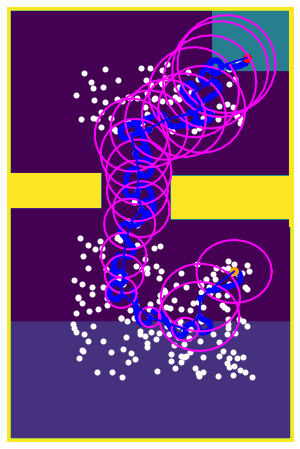

In [7]:
x_rng = np.random.default_rng(seed = 5)
y_rng = np.random.default_rng(seed = 181)
theta_rng = np.random.default_rng(seed = 39)

def calc_radius(n: int, d: int = 2) -> float:
    radius = (np.log(n) / n) ** (1 / 2) * 75
    return radius

x_observability = 250

env[x_observability:280,3:env.shape[1]-3] = 1

def is_state_observable(env,state, obs_val):
    global x_observability
    if(state[0] > x_observability): 
        return True
    else: 
        return False
    
initial_point = np.array([210.0, 180.0, np.pi/2])
finish_point = np.array([40.0, 190.0, -np.pi])

step = 15
initial_covariance_matrix = 900 
ellipse_number_of_points = 30
d_radius = 5
ang_weignt = 1 * d_radius/(2*np.pi) 

g = GraphRRTBNX(initial_point, finish_point,  step, initial_covariance_matrix,ellipse_number_of_points,d_radius,ang_weignt)
iterations = 500
g.rttb(iterations)

local_planner = Dubins(radius = 5, point_separation= 1)
goal_radius = 20
plan,nodes = g.create_plan(goal_radius)

ellipses_steps = 1

exp_name = "DubinsUncertaintyStudy" 
name = exp_name + " step-"+ str(step) + " iters-" + str(iterations) +" near-radius " + str(5) + ".png"
path_plot(env,plan, nodes,local_planner,name,ellipses_steps,ellipse_number_of_points, g.G)

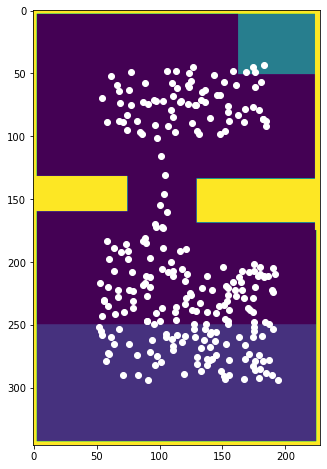

In [6]:
plot_all_graph_points(env,g.G)